# Using SMAC to optimize an artificial black box function (Full example)

* Installation of SMAC and its dependencies
* Definition of cheap 1d function
* Plotting this function
* Using SMAC's fmin interface to optimize the function
* Plotting of how SMAC performed over time
* Visualizing SMAC's acquisition function
* Using other hyperparameters of SMAC's random forest to obtain better predictions

## Installation of SMAC and its Dependencies

In [1]:
!apt-get install swig -y
!pip install Cython
!pip install pyrfr==0.8.0 --no-cache --user
# hack to find pyrfr
import sys
sys.path.insert(0,"./.local/lib/python3.6/site-packages")

!pip install git+https://github.com/automl/SMAC3.git@development

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,080 kB of archives.
After this operation, 5,657 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig3.0 amd64 3.0.10-1.2 [1,074 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig amd64 3.0.10-1.2 [6,384 B]
Fetched 1,080 kB in 0s (1,259 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.10-1.2_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.2) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.10-1.2_amd64.deb ...


    100% |████████████████████████████████| 1.9MB 14.0MB/s 
    100% |████████████████████████████████| 2.2MB 11.2MB/s 
    100% |████████████████████████████████| 184kB 19.7MB/s 
    100% |████████████████████████████████| 163kB 18.2MB/s 
    100% |████████████████████████████████| 552kB 19.3MB/s 
    100% |████████████████████████████████| 71kB 22.0MB/s 
    100% |████████████████████████████████| 6.8MB 5.5MB/s 
  Running setup.py bdist_wheel for smac ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghz7vggz/wheels/f4/8d/4f/2ba4cb80693f139ea06c2e8541e012a93738fb56bc1e43a202
  Running setup.py bdist_wheel for pynisher ... - done
  Stored in directory: /content/.cache/pip/wheels/81/35/cb/37fe9c279ac6e56fc8805e146a431c27550dce1ad868ffa04e
  Running setup.py bdist_wheel for ConfigSpace ... - \ | / -

 \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/04/bb/ce/b64b66d9b04eb27445cc5445f69eb35dcd2b5884122be62f13
Successfully built smac pynisher ConfigSpace


## Define Function to be optimized

In [0]:
import math
import numpy as np

def test_func(x):
    # x is vector; here of length 1
    x = x[0]
    return math.cos(x) * x**2 + x 

## Plot Function

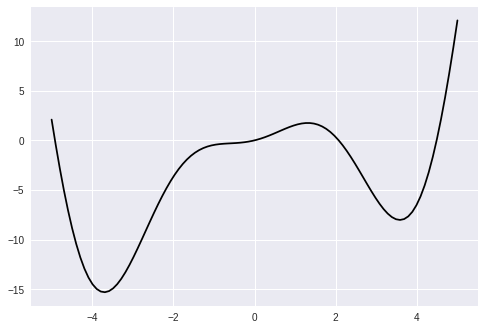

In [3]:
x_points = np.linspace(start=-5,stop=5,num=100) 
y_points = list(map(test_func,map(lambda x: [x], x_points)))

import matplotlib.pyplot as plt
plt.plot(x_points, y_points, 'k')

## Optimize with SMAC

In [4]:
from smac.facade.func_facade import fmin_smac

MAX_FUN = 30

x, cost, smac = fmin_smac(func=test_func,
                       x0=[-0], # default values
                       bounds=[(-5, 5)], # bounds of each x
                       maxfun=MAX_FUN, # maximal number of function evaluations 
                       rng=1234 # random seed
                       )

print("Best x: %f" %(x[0]))
print("Best y: %f" %(cost))

Best x: -3.680711
Best y: -15.306770


## Plot Found Solution

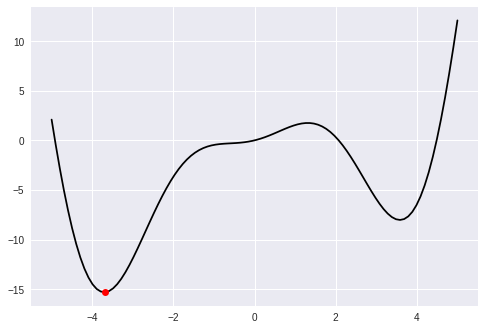

In [5]:
plt.plot(x_points, y_points, 'k', x, [cost], 'ro')

## How has SMAC performed over time?

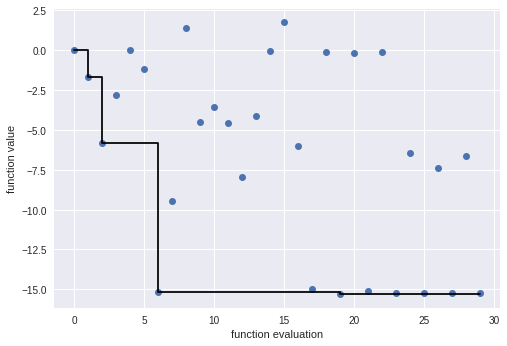

In [6]:
import numpy as np
# get runhistory, all runs ever evaluated by smac
runhistory = smac.get_runhistory()

# extract x value and corresponding y value
x_smac = []
y_smac = []
for entry in runhistory.data: # iterate over data because it is an OrderedDict
  config_id = entry.config_id # look up config id
  config = runhistory.ids_config[config_id] # look up config
  y_ = runhistory.get_cost(config) # get cost
  x_ = config["x1"] # there is only one entry in our example
  x_smac.append(x_)
  y_smac.append(y_)
x_smac = np.array(x_smac)
y_smac = np.array(y_smac)


# Plotting
plt.plot(y_smac, 'o')
plt.xlabel('function evaluation')
plt.ylabel('function value')

# let's plot only the best function value at each time step
y_best = np.zeros(MAX_FUN)
for id in range(MAX_FUN):
  y_best[id] = np.min(y_smac[:id+1])
  
plt.step(y_best, 'k', where="post") # please note that we use step function!

## Visualizing the Acquisition Function (Expected Improvement)

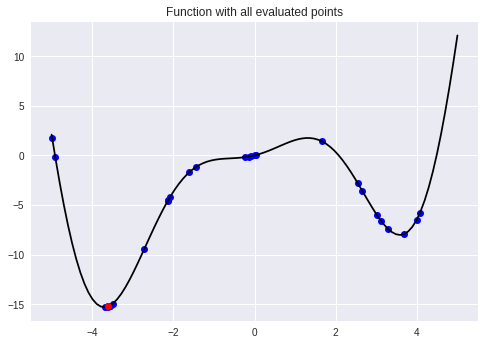

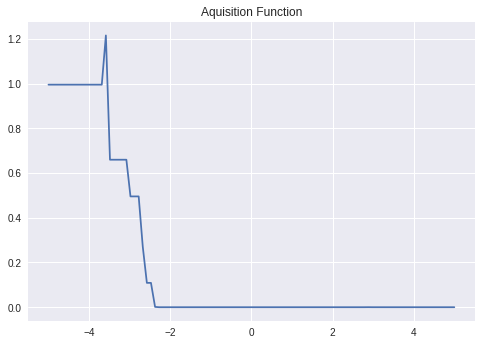

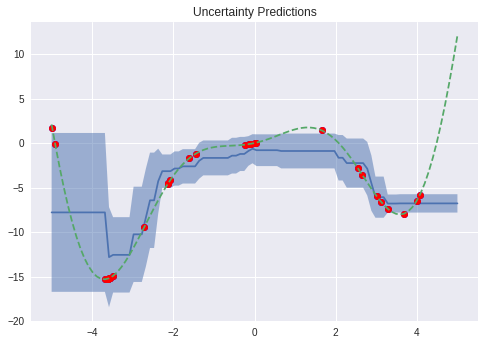

In [9]:
from smac.optimizer.acquisition import EI
from smac.epm.rf_with_instances import RandomForestWithInstances


def plot_state(smac, model, cutoff):
  '''
    plot function with all evaluated points,
    EI acquisition function
    Predictions with uncertainties
  '''
  
  # Plot all evaluated points on the function
  fig1 = plt.figure()
  ax = plt.plot(x_smac[:cutoff], y_smac[:cutoff], 'bo', x_points, y_points, 'k', x_smac[cutoff-1], y_smac[cutoff-1], 'ro')
  plt.title("Function with all evaluated points")


  # extract (again) all points from the runhistory of SMAC
  X, Y = smac.solver.rh2EPM.transform(runhistory)
  
  x_smac_ = np.array([[x] for x in x_smac])
  y_smac_ = np.array([[y] for y in y_smac])
  
  
  x_smac_ = x_smac_[:cutoff]
  y_smac_ = y_smac_[:cutoff]
  
  
  # cost all points for x
  x_points_ = np.array([[x] for x in x_points])

  model.train(x_smac_, y_smac_)

  acq_func = EI(model=model)
  acq_func.update(model=model, eta=np.min(y_smac[:cutoff]))

  x_points_ = np.array([[x] for x in x_points])
  acq_values = acq_func._compute(X=x_points_)[:,0]

  # plot acquisition function
  y_mean, y_var = model.predict(x_points_)
  y_mean = y_mean[:,0]
  y_std = np.sqrt(y_var)[:,0]

  fig1 = plt.figure()
  ax1 = fig1.add_subplot(111)
  ax1.plot(x_points, acq_values)
  plt.title("Aquisition Function")

  # plot uncertainties
  fig1 = plt.figure()
  ax1 = fig1.add_subplot(111)
  ax1.plot(x_points,y_mean)
  ax1.fill_between(x_points, y_mean-y_std, 
                   y_mean+y_std,alpha=0.5)
  ax1.plot(x_smac[:cutoff], y_smac[:cutoff], 'bo')
  ax1.plot(x_smac[:cutoff], y_smac[:cutoff], 'ro')
  ax1.plot(x_points, y_points, '--')
  plt.title("Uncertainty Predictions")
  
  

# set up a EPM (empirical performance model)
types, bounds = np.array([0]), np.array([[0.0, 1.0]])
model = RandomForestWithInstances(types=types, 
                                  bounds=bounds,
                                  instance_features=None,
                                  seed=12345
                                 )

plot_state(smac, model, MAX_FUN)

## Better Predictions with RFs

The above predictions are very unsatisfying for a smooth function.
In the following, we change the hyperparameters of the random forest to get better predictions:

 * no pruning
 * many trees
 * no bootstrapping
 
 
 Note: The extrapolation of RFs is not quite good.
 
 Note(2): To compare both RF hyperparameter settings, we use the same data points as above---no new SMAC runs to generate new points with the modified RF.

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


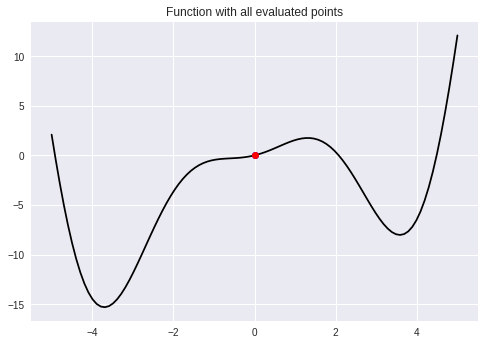

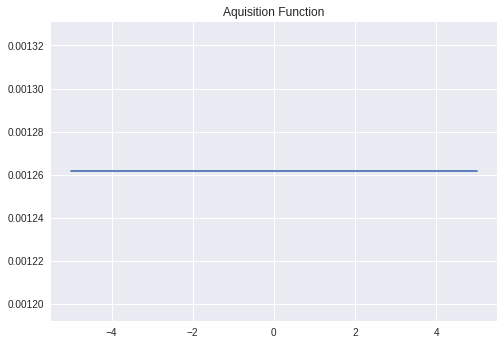

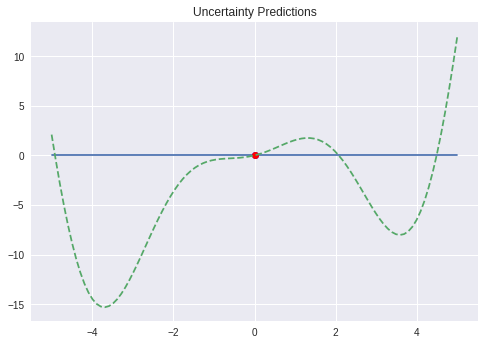

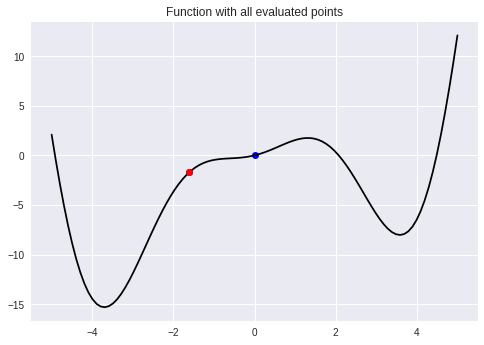

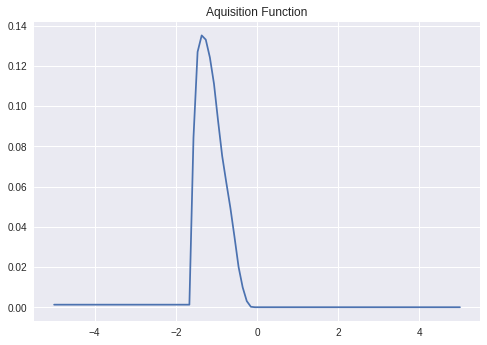

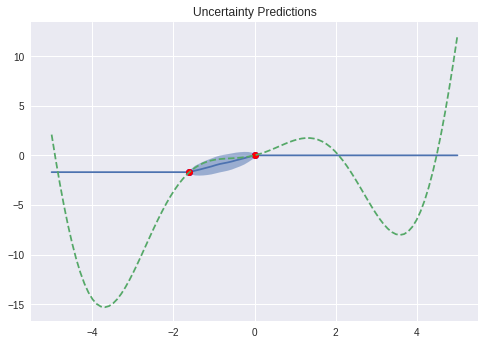

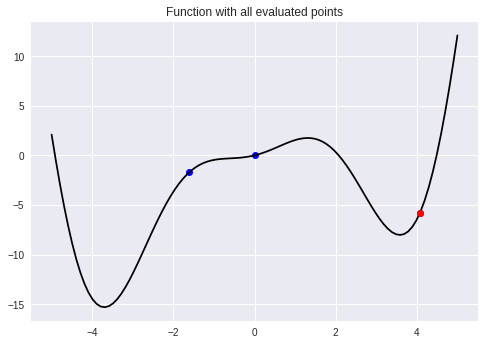

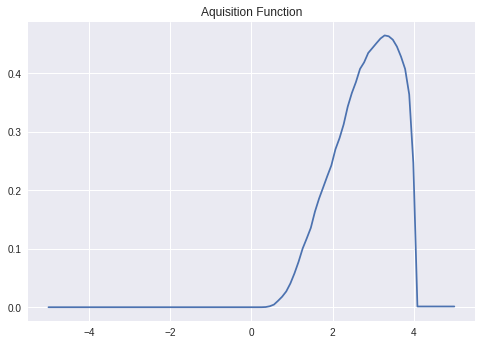

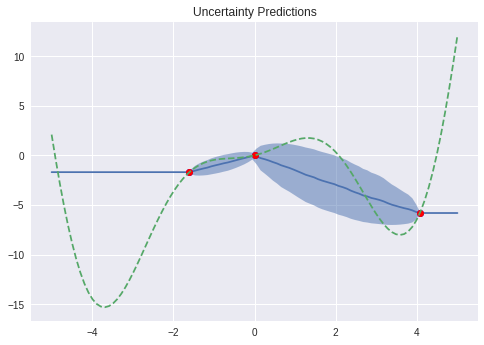

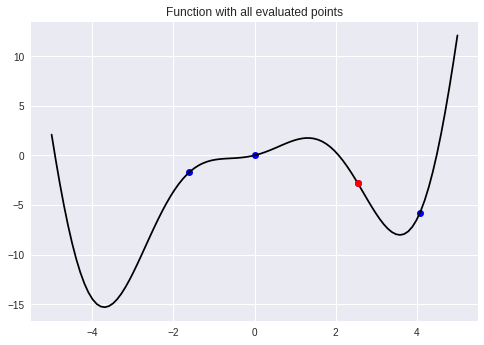

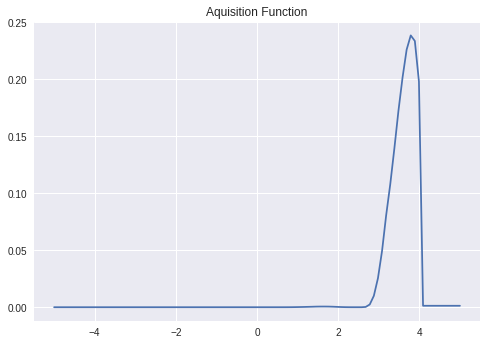

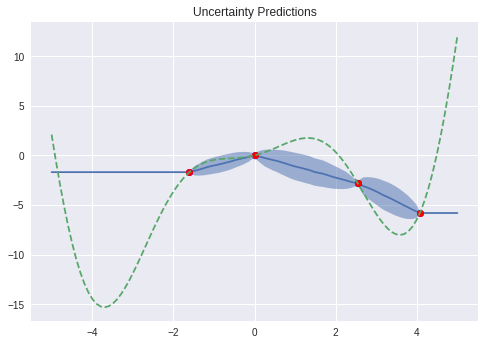

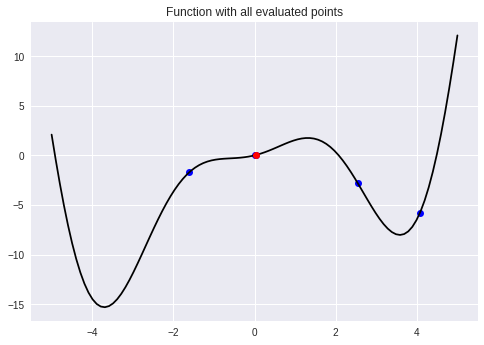

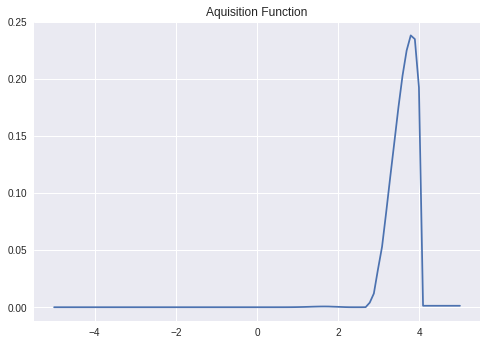

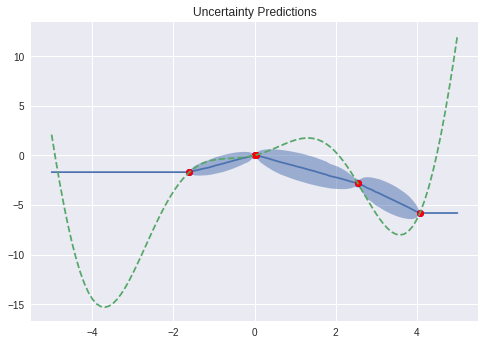

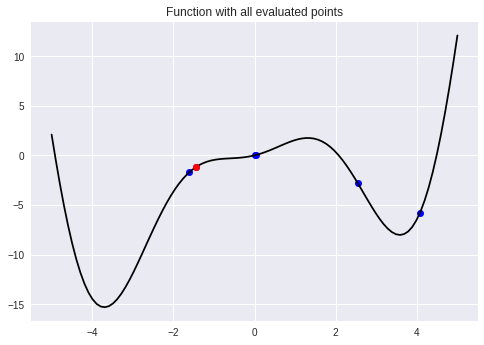

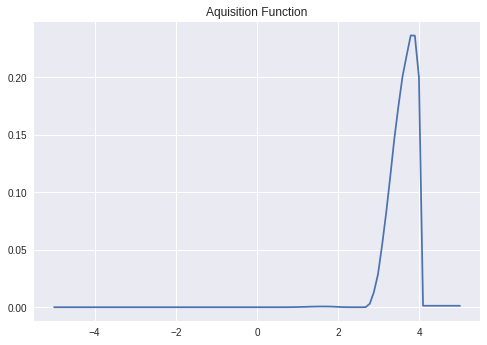

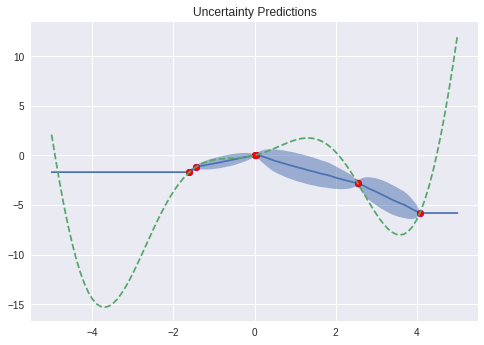

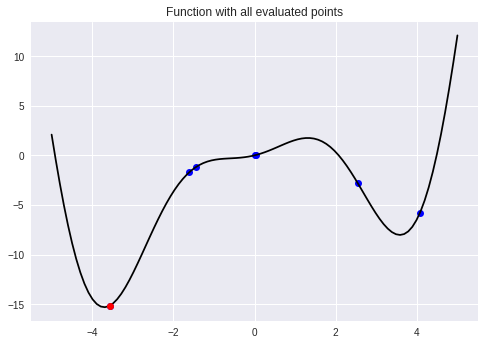

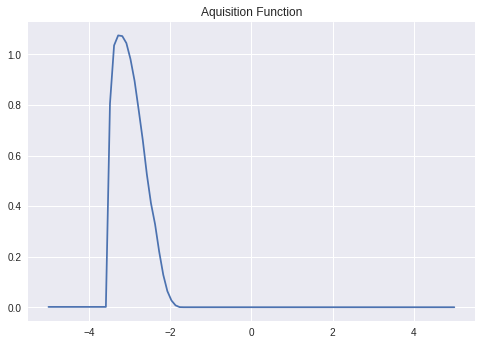

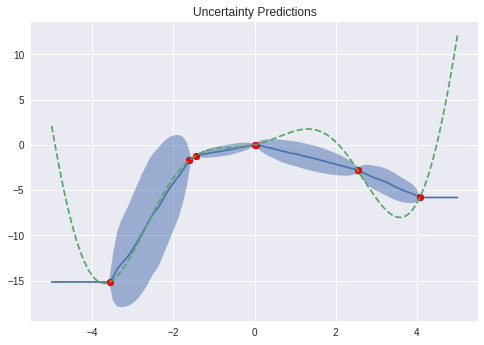

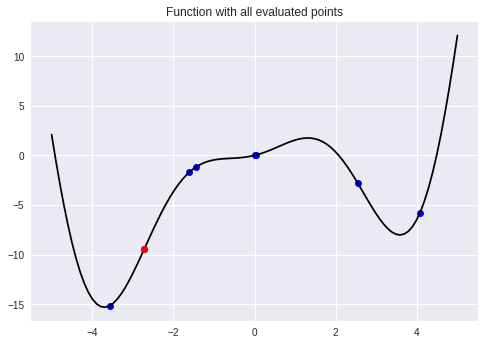

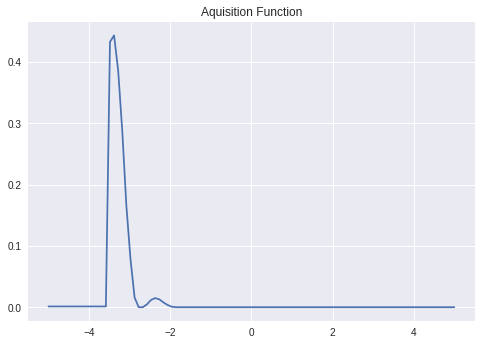

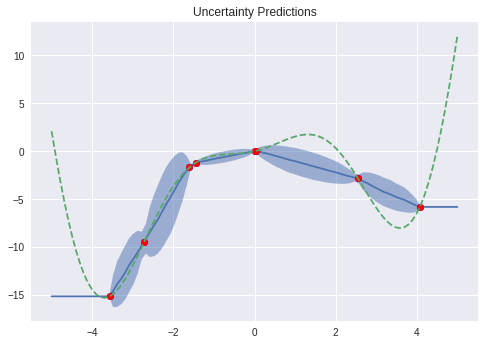

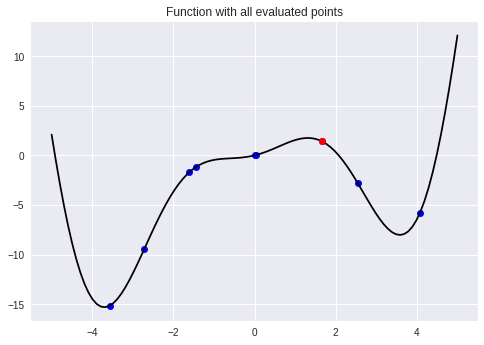

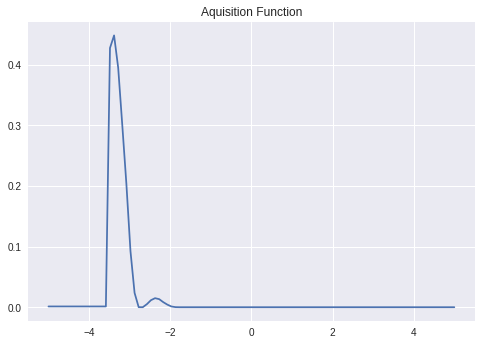

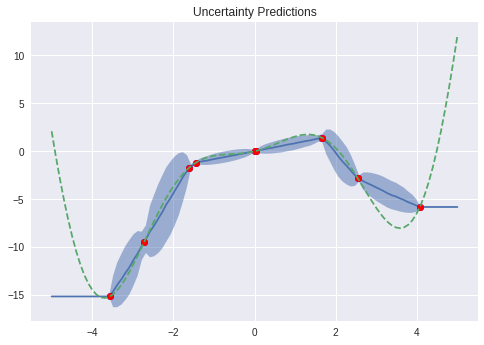

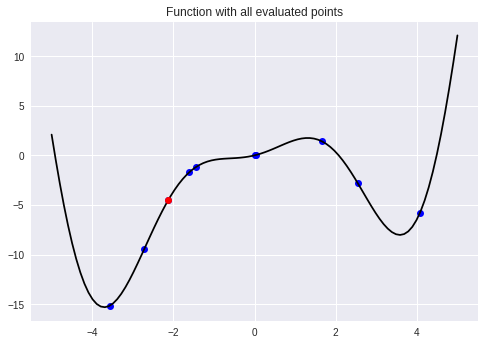

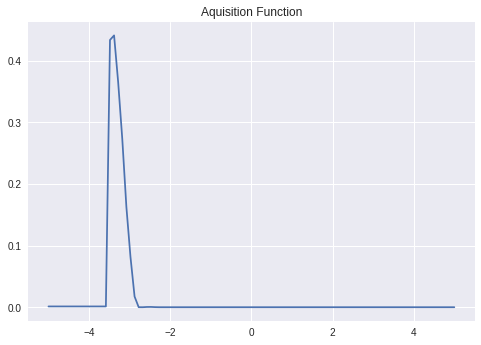

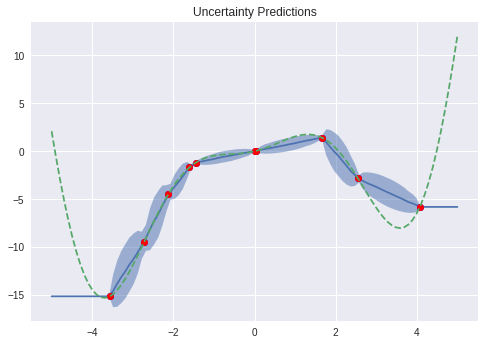

In [10]:
model = RandomForestWithInstances(types=types, 
                                  bounds=bounds,
                                  instance_features=None,
                                  seed=12345,
                                  pca_components=12345,
                                  ratio_features=1,
                                  num_trees=1000,
                                  min_samples_split=1,
                                  min_samples_leaf=1,
                                  max_depth=100000,
                                  do_bootstrapping=False,
                                  n_points_per_tree=-1,
                                  eps_purity=0
                                 )
for i in range(1,11):
  plot_state(smac, model, i)